In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [162]:
df = pd.read_csv("synthetic_budget_data.csv")
print(df.head())

  User_ID  Year  Month                               Scenario  Salary  \
0    U001  2024      1  Stable Salary & Stable Fixed Expenses   86596   
1    U001  2024      2  Stable Salary & Stable Fixed Expenses   86596   
2    U001  2024      3  Stable Salary & Stable Fixed Expenses   86596   
3    U001  2024      4  Stable Salary & Stable Fixed Expenses   86596   
4    U001  2024      5  Stable Salary & Stable Fixed Expenses   86596   

   Fixed_Expenses  Variable_Expenses  Total_Expenses  Savings  Savings_Rate  \
0         26645.0              55873         82518.0   4078.0          4.71   
1         26645.0              67652         94297.0  -7701.0         -8.89   
2         26645.0              61553         88198.0  -1602.0         -1.85   
3         26645.0              67360         94005.0  -7409.0         -8.56   
4         26645.0              67857         94502.0  -7906.0         -9.13   

   Expense_Fluctuation Risk_Category  
0                 0.02     High Risk  
1       

In [163]:
df.drop(columns=['Scenario'], inplace=True)
print(df.head())

  User_ID  Year  Month  Salary  Fixed_Expenses  Variable_Expenses  \
0    U001  2024      1   86596         26645.0              55873   
1    U001  2024      2   86596         26645.0              67652   
2    U001  2024      3   86596         26645.0              61553   
3    U001  2024      4   86596         26645.0              67360   
4    U001  2024      5   86596         26645.0              67857   

   Total_Expenses  Savings  Savings_Rate  Expense_Fluctuation Risk_Category  
0         82518.0   4078.0          4.71                 0.02     High Risk  
1         94297.0  -7701.0         -8.89                -0.03     High Risk  
2         88198.0  -1602.0         -1.85                -0.04     High Risk  
3         94005.0  -7409.0         -8.56                -0.04     High Risk  
4         94502.0  -7906.0         -9.13                 0.01     High Risk  


In [164]:
risk_mapping = {'Low Risk': 1, 'Medium Risk': 2, 'High Risk': 3}
df['Risk_Category'] = df['Risk_Category'].map(risk_mapping)
print(df.head())

  User_ID  Year  Month  Salary  Fixed_Expenses  Variable_Expenses  \
0    U001  2024      1   86596         26645.0              55873   
1    U001  2024      2   86596         26645.0              67652   
2    U001  2024      3   86596         26645.0              61553   
3    U001  2024      4   86596         26645.0              67360   
4    U001  2024      5   86596         26645.0              67857   

   Total_Expenses  Savings  Savings_Rate  Expense_Fluctuation  Risk_Category  
0         82518.0   4078.0          4.71                 0.02              3  
1         94297.0  -7701.0         -8.89                -0.03              3  
2         88198.0  -1602.0         -1.85                -0.04              3  
3         94005.0  -7409.0         -8.56                -0.04              3  
4         94502.0  -7906.0         -9.13                 0.01              3  


In [165]:
# Selecting relevant columns
features = ['Salary', 'Fixed_Expenses', 'Variable_Expenses', 'Total_Expenses', 'Savings_Rate']
target = 'Savings'

In [166]:
# Scaling data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
df[features] = scaler_X.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[[target]])

In [167]:
# Creating sequences for LSTM
# Ensure sequences are created per user
sequence_length = 11  # Using past 12 months for prediction

In [168]:
# Check if User_ID exists and is correctly formatted
print("Dataset Columns:", df.columns)
print("Unique User_IDs:", df['User_ID'].nunique())
print(df[['User_ID']].head())  # Ensure User_ID is properly loaded


Dataset Columns: Index(['User_ID', 'Year', 'Month', 'Salary', 'Fixed_Expenses',
       'Variable_Expenses', 'Total_Expenses', 'Savings', 'Savings_Rate',
       'Expense_Fluctuation', 'Risk_Category'],
      dtype='object')
Unique User_IDs: 1000
  User_ID
0    U001
1    U001
2    U001
3    U001
4    U001


In [169]:
def create_sequences(df, sequence_length):
    X, y = [], []
    # Ensure User_ID exists
    if 'User_ID' not in df.columns:
        raise ValueError("Column 'User_ID' is missing from the dataset.")
    user_groups = df.groupby('User_ID')
    for user_id, group in user_groups:
        print(f"Processing User: {user_id}, Total Months: {len(group)}")  # Debugging
        data = group[features].values
        target_values = group[target].values
        # Ensure user has enough data for sequence creation
        if len(data) <= sequence_length:
            print(f"Skipping User {user_id} (Not enough data: {len(data)} months)")
            continue
        
        for i in range(len(data) - sequence_length):
            X.append(data[i:i + sequence_length])
            y.append(target_values[i + sequence_length])
    X, y = np.array(X), np.array(y).reshape(-1, 1)  # Ensure correct dimensions
    # return np.array(X), np.array(y).reshape(-1, 1) 
    print("Final X shape:", X.shape)  # Debugging
    print("Final y shape:", y.shape)  # Debugging
    
    return X, y


In [170]:
X, y = create_sequences(df, sequence_length)

Processing User: U001, Total Months: 12
Processing User: U002, Total Months: 12
Processing User: U003, Total Months: 12
Processing User: U004, Total Months: 12
Processing User: U005, Total Months: 12
Processing User: U006, Total Months: 12
Processing User: U007, Total Months: 12
Processing User: U008, Total Months: 12
Processing User: U009, Total Months: 12
Processing User: U010, Total Months: 12
Processing User: U011, Total Months: 12
Processing User: U012, Total Months: 12
Processing User: U013, Total Months: 12
Processing User: U014, Total Months: 12
Processing User: U015, Total Months: 12
Processing User: U016, Total Months: 12
Processing User: U017, Total Months: 12
Processing User: U018, Total Months: 12
Processing User: U019, Total Months: 12
Processing User: U020, Total Months: 12
Processing User: U021, Total Months: 12
Processing User: U022, Total Months: 12
Processing User: U023, Total Months: 12
Processing User: U024, Total Months: 12
Processing User: U025, Total Months: 12


In [171]:
# Verify dimensions
print("X shape:", X.shape)  # Should be (num_samples, sequence_length, num_features)
print("y shape:", y.shape)  # Should be (num_samples, 1)

X shape: (1000, 11, 5)
y shape: (1000, 1)


In [172]:
# Splitting into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [173]:
# Build LSTM Model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

C:\Users\debajda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [174]:
model.compile(optimizer='adam', loss='mse')

In [175]:
# Adding EarlyStopping to avoid overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [176]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=6, validation_data=(X_test, y_test), 
                    verbose=1)


Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0425 - val_loss: 0.0064
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 9/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 10/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 11/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 12/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 

In [177]:
# Predictions
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [178]:
# Convert predictions back to original scale
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred)

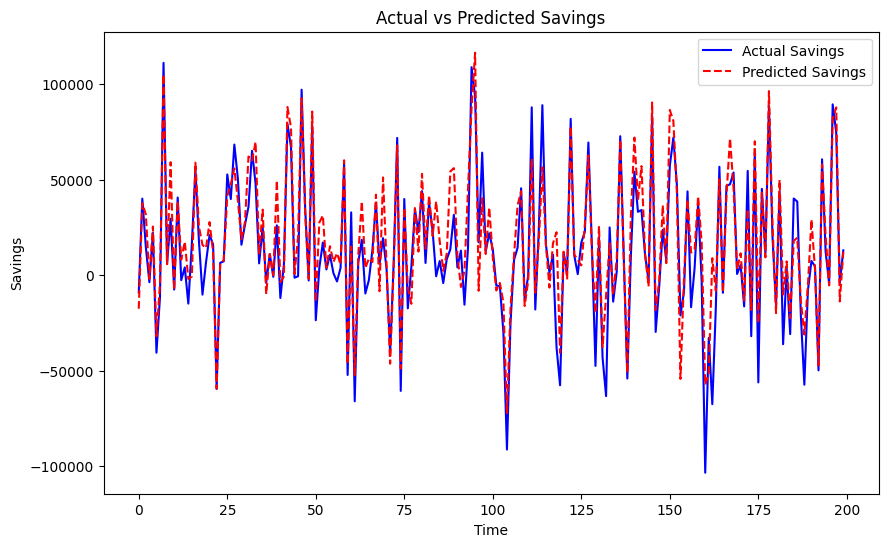

In [179]:
# Plot actual vs predicted savings
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual Savings', color='blue')
plt.plot(y_pred_inv, label='Predicted Savings', linestyle='dashed', color='red')
plt.xlabel("Time")
plt.ylabel("Savings")
plt.legend()
plt.title("Actual vs Predicted Savings")
plt.show()

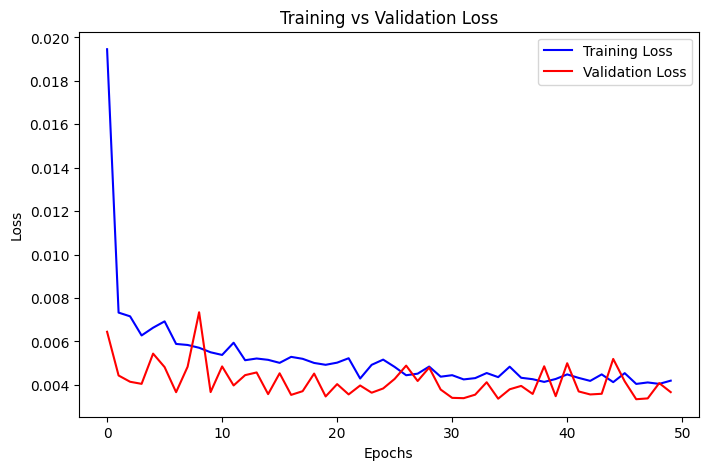

In [180]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [181]:
def predict_savings_for_user(user_id, df, model, scaler_X, scaler_y, sequence_length):
    user_data = df[df['User_ID'] == user_id].sort_values(by=['Year', 'Month'])
    if len(user_data) < sequence_length:
        print("Not enough data for this user to make a prediction.")
        return None
    
    last_sequence = user_data[features].values[-sequence_length:]
    last_sequence = scaler_X.transform(last_sequence)
    last_sequence = np.expand_dims(last_sequence, axis=0)  # Reshape for model input
    
    predicted_savings = model.predict(last_sequence)
    predicted_savings = scaler_y.inverse_transform(predicted_savings.reshape(-1, 1))
    
    print(f"Predicted savings for User {user_id} in January 2025: {predicted_savings[0][0]}")
    return predicted_savings[0][0]

In [182]:
# Example usage:
predict_savings_for_user("U002", df, model, scaler_X, scaler_y, sequence_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted savings for User U002 in January 2025: 457.5369567871094


C:\Users\debajda\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


np.float32(457.53696)